# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/gdrive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [33]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [34]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [35]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [36]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [38]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [39]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [40]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [42]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [0]:
final=final.sort_values(by=['Time'])
final = final.reset_index(drop=True)

In [44]:
Score=final.Score
Score.shape

(87773,)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [45]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!<br /><br />(For those wo

In [46]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [47]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!(For those wondering, this mix requ

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [49]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This gum is my absolute favorite. By purchasing on amazon I can get the savings of large quanities at a very good price. I highly recommend to all gum chewers. Plus as you enjoy the peppermint flavor and freshing of breath you are whitening your teeth all at the same time.


In [50]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [51]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This gum is my absolute favorite By purchasing on amazon I can get the savings of large quanities at a very good price I highly recommend to all gum chewers Plus as you enjoy the peppermint flavor and freshing of breath you are whitening your teeth all at the same time 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [53]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2560.49it/s]


In [54]:
preprocessed_reviews[1500]

'gum absolute favorite purchasing amazon get savings large quanities good price highly recommend gum chewers plus enjoy peppermint flavor freshing breath whitening teeth time'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

**SPLITTING FUNCTIONS**

In [0]:
from sklearn.model_selection import train_test_split
import math

preprocessed_reviews=np.array(preprocessed_reviews)

def splitter(X,Y):
  
  X_train =  X[:int(math.ceil(Y.shape[0])*.7)] 
  X_test = X[int(math.ceil(Y.shape[0])*.7):]
  y_train = Y[:int(math.ceil(Y.shape[0])*.7)]
  y_test =  Y[int(math.ceil(Y.shape[0])*.7):]
  return (X_train, X_test, y_train, y_test)

def random_splitter(X,Y):
  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)
  return (X_train, X_test, y_train, y_test)


In [0]:
TRAIN,TEST,Y_TRAIN,Y_TEST =splitter(preprocessed_reviews,Score)
TRAIN_CV,TEST_CV,Y_TRAIN_CV,Y_TEST_CV=random_splitter(TRAIN,Y_TRAIN)

**CLASSIFIER AND HYPER-PARAMETER TUNING**

In [0]:
#def  function
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
import seaborn as sn
import math
import time
from sklearn.metrics import roc_curve, auc

alpha_values=[10**-5, 10**-4,10**-3,10**-2,10**-1,10**1,10**2,10**3,10**4,10**5]


#HYPERPARAMETER TUNING


def BEST_ALPHA_Linear(data):
  k_fold_scores1=[]
  k_fold_scores2=[]
  
  for i in alpha_values:
    
    clf = linear_model.SGDClassifier(loss="hinge",alpha=i,penalty='l2')
    
    calib=CalibratedClassifierCV(clf,method='isotonic',cv=5)
    
    calib.fit(data[0],data[1])
 
    
    pred1=calib.predict_proba(data[0])[:,1]
 
    scores1=roc_auc_score(data[1],pred1)
    
    pred2=calib.predict_proba(data[2])[:,1]
 
    scores2=roc_auc_score(data[3],pred2)
    
    
    
    k_fold_scores1.append(scores1)
    k_fold_scores2.append(scores2)
    
    
  best_alpha=np.argmax(k_fold_scores2)
  
  plt.figure(figsize=(15,9))
  
  plt.plot(np.log(alpha_values),1-(np.array(k_fold_scores1)),color='blue')
  plt.plot(np.log(alpha_values),1-(np.array(k_fold_scores2)),color="red")
 
  plt.title("Misclassificaiton error vs. Alpha Value")
  plt.xlabel('Log of Alpha Value')
  plt.ylabel('Misclassification error')
  plt.legend(['Training Set', 'Cross Validation Set'], loc='upper left')
  plt.show()
  

  print("The optimal value of alpha is ",alpha_values[best_alpha],"with AUC Score :",k_fold_scores2[best_alpha])
  
  return alpha_values[best_alpha]

####################################################################################################################################################

def BEST_ALPHA_rbf(data):
  
  k_fold_scores1=[]
  k_fold_scores2=[]
  
  for i in alpha_values:
    
    clf = SVC(C=i, kernel="rbf",gamma='auto')
    
    calib=CalibratedClassifierCV(clf,method='isotonic',cv=5)
    
    calib.fit(data[0],data[1])
 
    
    pred1=calib.predict_proba(data[0])[:,1]
 
    scores1=roc_auc_score(data[1],pred1)
    
    pred2=calib.predict_proba(data[2])[:,1]
 
    scores2=roc_auc_score(data[3],pred2)
    
    
    
    k_fold_scores1.append(scores1)
    k_fold_scores2.append(scores2)
    
    
  best_alpha=np.argmax(k_fold_scores2)
  
  plt.figure(figsize=(15,9))
  
  plt.plot(np.log(alpha_values),1-(np.array(k_fold_scores1)),color='blue')
  plt.plot(np.log(alpha_values),1-(np.array(k_fold_scores2)),color="red")
 
  plt.title("Misclassificaiton error vs. Alpha Value")
  plt.xlabel('Log of Alpha Value')
  plt.ylabel('Misclassification error')
  plt.legend(['Training Set', 'Cross Validation Set'], loc='lower right')
  plt.show()
  

  print("The optimal value of alpha is ",alpha_values[best_alpha],"with AUC Score :",k_fold_scores2[best_alpha])
  
  return alpha_values[best_alpha]


def rbf_Svm(data,i):
  
    clf = SVC(C=i, kernel="rbf",gamma='auto')
    
    
    clf.fit(data[0],data[1])
    
    calib=CalibratedClassifierCV(clf,method='isotonic',cv=5)
    
    calib.fit(data[0],data[1])
 
    
    pred1=calib.predict_proba(data[0])[:,1]
    pred2=calib.predict_proba(data[2])[:,1]
 
    score1=roc_auc_score(data[1],pred1)
    score2=roc_auc_score(data[3],pred2)
  
  
    pred1=np.round_(pred1)
    pred2=np.round_(pred2)
 
    print("Confusion matrix for train followed by test")
    print()
    matrix=confusion_matrix(data[1],pred1)
    df=pd.DataFrame(matrix,index=['Positive','Negative'],columns=['Positive','Negative'])
    plt.figure(figsize = (10,7))
    sn.heatmap(df, annot=True,fmt='g')
    print()
    matrix2=confusion_matrix(data[3],pred2)
    df=pd.DataFrame(matrix2,index=['Positive','Negative'],columns=['Positive','Negative'])
    plt.figure(figsize = (10,7))
    sn.heatmap(df, annot=True,fmt='g')
    
    print()

    fpr, tpr, thresholds = roc_curve(data[1],pred1)
  

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve train (area = %0.2f)' % score1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')

    fpr2, tpr2, thresholds2 = roc_curve(data[3],pred2)
  
    plt.plot(fpr2, tpr2, color='red', lw=1, label='ROC curve test (area = %0.2f)' % score2)
    plt.legend(loc="lower right")
    plt.show()
    plt.show()
    
    return score2,clf

def Linear_Svm(data,i):
  
    clf = linear_model.SGDClassifier(loss="hinge",alpha=i,penalty='l2')
    
    clf.fit(data[0],data[1])
    
    calib=CalibratedClassifierCV(clf,method='isotonic',cv=5)
    
    calib.fit(data[0],data[1])
 
    
    pred1=calib.predict_proba(data[0])[:,1]
    pred2=calib.predict_proba(data[2])[:,1]
 
    score1=roc_auc_score(data[1],pred1)
    score2=roc_auc_score(data[3],pred2)
  
  
    pred1=np.round_(pred1)
    pred2=np.round_(pred2)
 
    print("Confusion matrix for train followed by test")
    print()
    matrix=confusion_matrix(data[1],pred1)
    df=pd.DataFrame(matrix,index=['Positive','Negative'],columns=['Positive','Negative'])
    plt.figure(figsize = (10,7))
    sn.heatmap(df, annot=True,fmt='g')
    print()
    matrix2=confusion_matrix(data[3],pred2)
    df=pd.DataFrame(matrix2,index=['Positive','Negative'],columns=['Positive','Negative'])
    plt.figure(figsize = (10,7))
    sn.heatmap(df, annot=True,fmt='g')
    
    print()

    fpr, tpr, thresholds = roc_curve(data[1],pred1)
  

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve train (area = %0.2f)' % score1)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')


    fpr2, tpr2, thresholds2 = roc_curve(data[3],pred2)
  
    plt.plot(fpr2, tpr2, color='red', lw=1, label='ROC curve test (area = %0.2f)' % score2)
    plt.legend(loc="lower right")
    plt.show()
    plt.show()


    return score2,clf
 

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [0]:
#BoW

from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer()

BOW_TRAIN=vectorizer.fit_transform(TRAIN)
BOW_CV_TRAIN=vectorizer.transform(TRAIN_CV)
BOW_CV_TEST=vectorizer.transform(TEST_CV)
BOW_TEST=vectorizer.transform(TEST)

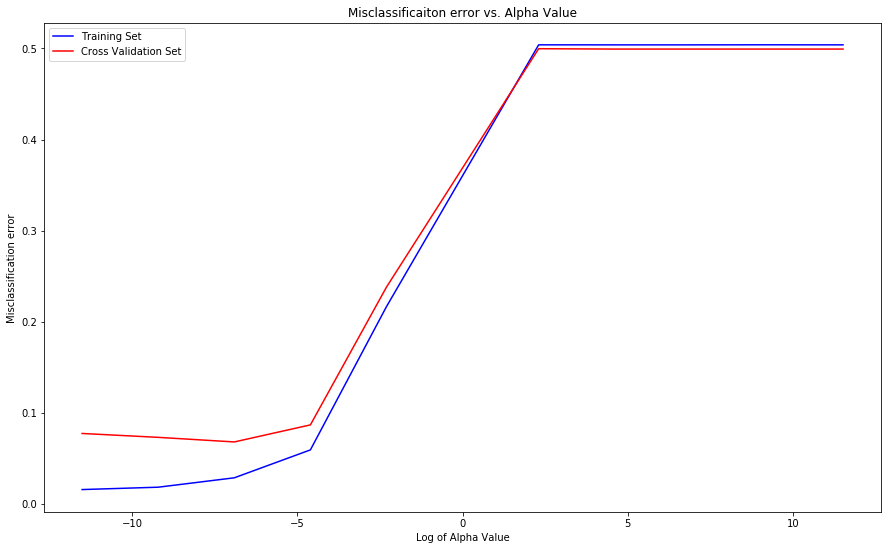

The optimal value of alpha is  0.001 with AUC Score : 0.9320363377751975


In [66]:

data=(BOW_CV_TRAIN,Y_TRAIN_CV,BOW_CV_TEST,Y_TEST_CV)
alpha=BEST_ALPHA_Linear(data)

**TEST DATA **

Confusion matrix for train followed by test





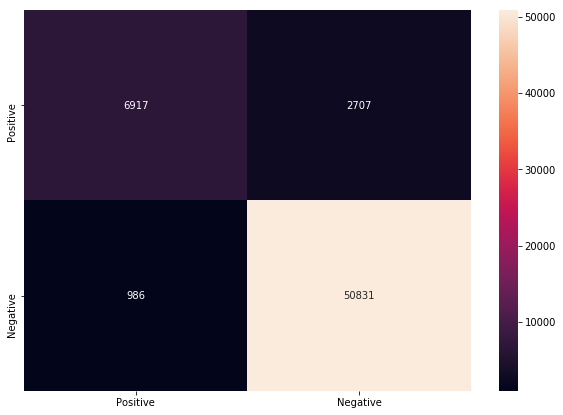

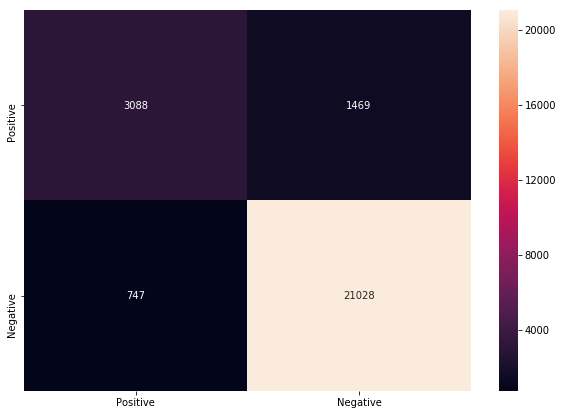

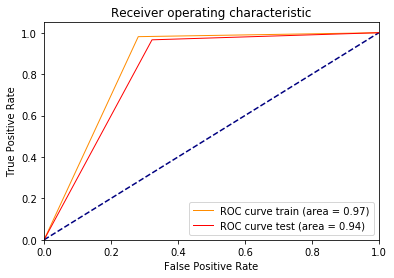

In [67]:

data=(BOW_TRAIN,Y_TRAIN,BOW_TEST,Y_TEST)
x=Linear_Svm(data,0.001)

In [68]:
print("The AUC score for BOW for alpha={} : {}".format(alpha,x[0]))

The AUC score for BOW for alpha=0.001 : 0.9426491183118185


**FEATURE IMPORTANCE**

In [0]:

def most_informative_feature_for_binary_classification(vectorizer, classifier):
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:10]
    topn_class2 = coefs[:-(11):-1]

    print("Top 10 negative features")
    for i in topn_class1:
       print(i)

    print("************************")
    print("Top 10 positive features")
    for i in topn_class2:
      print(i)

most_informative_feature_for_binary_classification(vectorizer,x[1])

Top 10 negative features
(-1.082514666150742, 'worst')
(-0.9660108455784643, 'disappointing')
(-0.8689243284349003, 'terrible')
(-0.849507025006186, 'awful')
(-0.800963766434405, 'disappointment')
(-0.7475661820054458, 'horrible')
(-0.7087315751480187, 'waste')
(-0.7038772492908417, 'threw')
(-0.6747512941477722, 'disappointed')
(-0.6601883165762371, 'unfortunately')
************************
Top 10 positive features
(0.6844599458621292, 'delicious')
(0.6504796648618794, 'perfect')
(0.645625339004702, 'excellent')
(0.5631017994326724, 'wonderful')
(0.5436844960039584, 'amazing')
(0.5145585408608905, 'best')
(0.49514123743217636, 'loves')
(0.47086960814628714, 'awesome')
(0.4417436530032174, 'worried')
(0.4417436530032166, 'great')


### [5.1.2]  Applying Linear SVM on TF-IDF,<font color='red'> SET 2</font>

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(ngram_range=(1,2))

TF_TRAIN=vectorizer.fit_transform(TRAIN)
TF_CV_TRAIN=vectorizer.transform(TRAIN_CV)          
TF_CV_TEST=vectorizer.transform(TEST_CV)
tf_TEST=vectorizer.transform(TEST)

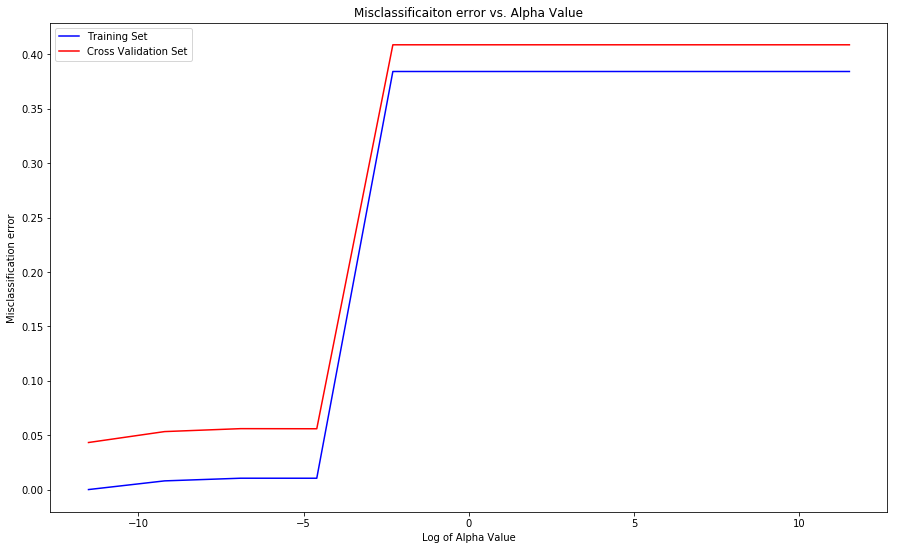

The optimal value of alpha is  1e-05 with AUC Score : 0.9567224431721398


In [71]:

data=(TF_CV_TRAIN,Y_TRAIN_CV,TF_CV_TEST,Y_TEST_CV)
alpha=BEST_ALPHA_Linear(data)

Confusion matrix for train followed by test





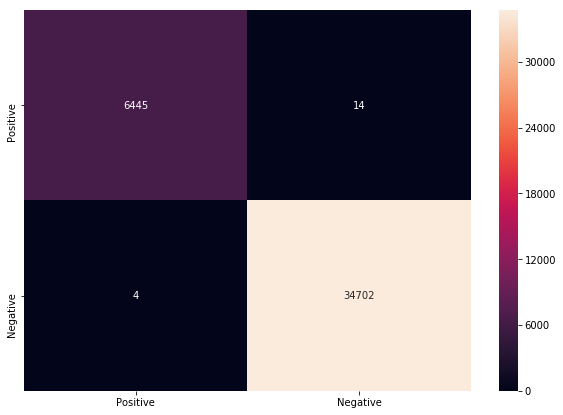

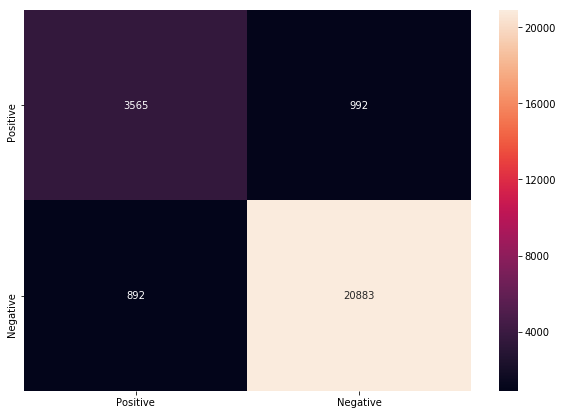

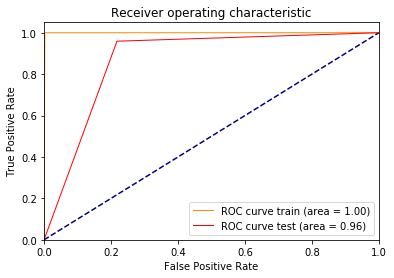

In [0]:

data=(TF_TRAIN,Y_TRAIN,tf_TEST,Y_TEST)

x=Linear_Svm(data,1e-05)

In [0]:
print("The AUC score for alpha={} : {}".format(alpha,x[0]))

The AUC score for alpha=1e-05 : 0.9637108628125893


**FEATURE IMPORTANCE**

In [0]:
def most_informative_feature_for_binary_classification(vectorizer, classifier):
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:10]
    topn_class2 = coefs[:-(11):-1]

    print("Top 10 negative features")
    for i in topn_class1:
       print(i)

    print("************************")
    print("Top 10 positive features")
    for i in topn_class2:
      print(i)

most_informative_feature_for_binary_classification(vectorizer,x[1])

Top 10 negative features
(-6.125563709881291, 'worst')
(-5.854477684957126, 'disappointed')
(-5.1903943782171345, 'terrible')
(-5.11612998860951, 'not good')
(-5.061973258082078, 'not')
(-5.022059592838096, 'disappointing')
(-4.868063106574026, 'awful')
(-4.842717158626492, 'not worth')
(-4.528256423551748, 'not recommend')
(-4.523327333452246, 'disappointment')
************************
Top 10 positive features
(6.729399758628813, 'great')
(5.534890765916916, 'delicious')
(5.42037077834713, 'good')
(5.257851268509044, 'best')
(4.738778454496646, 'perfect')
(4.701967219005281, 'not disappointed')
(4.2620347427255645, 'loves')
(4.103889871498188, 'excellent')
(3.9753971836485067, 'wonderful')
(3.9524906105564637, 'love')


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in TRAIN:
    list_of_sentance.append(sentance.split())

In [73]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8381884098052979), ('fantastic', 0.8357757925987244), ('awesome', 0.8111242055892944), ('excellent', 0.8038230538368225), ('good', 0.7924790382385254), ('wonderful', 0.7706174850463867), ('perfect', 0.7594425678253174), ('amazing', 0.731612503528595), ('decent', 0.6945902705192566), ('fabulous', 0.6942633986473083)]
[('best', 0.7568419575691223), ('greatest', 0.7396532893180847), ('tastiest', 0.7358432412147522), ('closest', 0.6911261677742004), ('coolest', 0.6673669219017029), ('nastiest', 0.616474986076355), ('ive', 0.6001958250999451), ('horrible', 0.5783698558807373), ('humble', 0.5679636001586914), ('disgusting', 0.563556969165802)]


In [76]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14799
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


In [0]:
list_of_sentance_train=[]
for sentance in TRAIN:
    list_of_sentance_train.append(sentance.split())

In [78]:
sentences_train=[]

for sentence in tqdm(list_of_sentance_train):
  count=0
  avg_sentence=np.zeros(50)
  for word in sentence:
    if word in w2v_words:
      avg_sentence+=w2v_model.wv[word]
      count+=1
      
  if count!=0:
    
    avg_sentence/=count
  
  sentences_train.append(avg_sentence)
  

100%|██████████| 61441/61441 [01:57<00:00, 523.19it/s]


In [0]:
list_of_sentance_train_cv=[]
for sentance in TRAIN_CV:
    list_of_sentance_train_cv.append(sentance.split())

In [80]:
sentences_train_cv=[]

for sentence in tqdm(list_of_sentance_train_cv):
  count=0
  avg_sentence=np.zeros(50)
  for word in sentence:
    if word in w2v_words:
      avg_sentence+=w2v_model.wv[word]
      count+=1
      
  if count!=0:
    
    avg_sentence/=count
  
  sentences_train_cv.append(avg_sentence)

100%|██████████| 41165/41165 [01:19<00:00, 514.80it/s]


In [0]:
list_of_sentance_test_cv=[]
for sentance in TEST_CV:
    list_of_sentance_test_cv.append(sentance.split())

In [82]:

from tqdm import tqdm


sentences_cv_test=[]

for sentence in tqdm(list_of_sentance_test_cv):
  count=0
  avg_sentence=np.zeros(50)
  for word in sentence:
    if word in w2v_words:
      avg_sentence+=w2v_model.wv[word]
      count+=1
      
  if count!=0:
    
    avg_sentence/=count
  
  sentences_cv_test.append(avg_sentence)

100%|██████████| 20276/20276 [00:38<00:00, 522.49it/s]


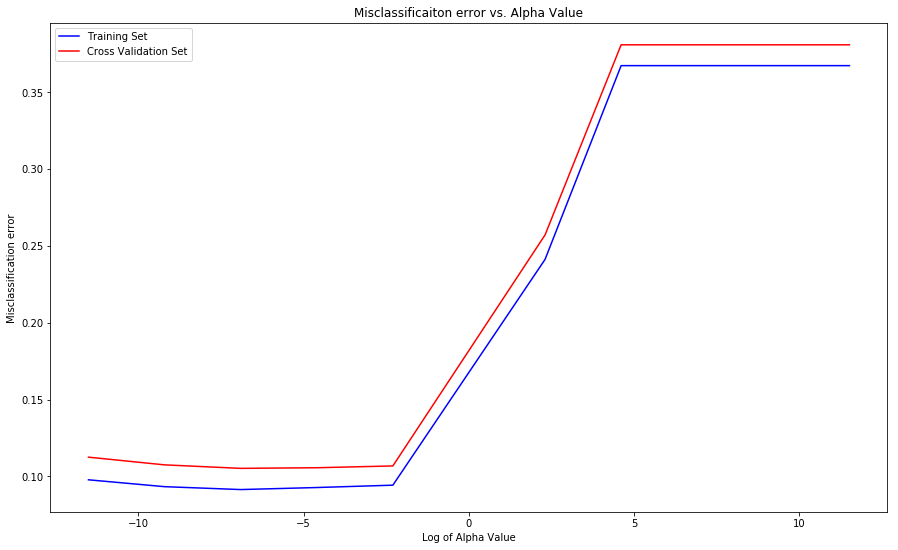

The optimal value of alpha is  0.001 with AUC Score : 0.8947139959578121


In [84]:

data=(sentences_train_cv,Y_TRAIN_CV,sentences_cv_test,Y_TEST_CV)
alpha=BEST_ALPHA_Linear(data)

In [0]:
list_of_sentance_test=[]
for sentance in TEST:
    list_of_sentance_test.append(sentance.split())

In [86]:
test_sentences=[]

for sentence in tqdm(list_of_sentance_test):
  count=0
  avg_sentence=np.zeros(50)
  for word in sentence:
    if word in w2v_words:
      avg_sentence+=w2v_model.wv[word]
      count+=1
      
  if count!=0:
    
    avg_sentence/=count
  
  test_sentences.append(avg_sentence)

100%|██████████| 26332/26332 [00:52<00:00, 501.63it/s]


Confusion matrix for train followed by test





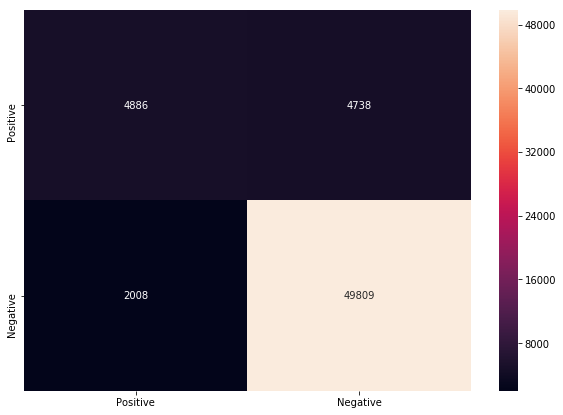

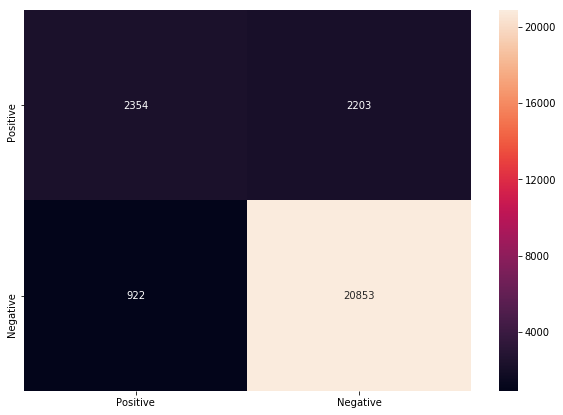

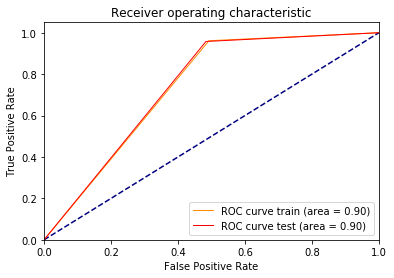

In [87]:
data=(sentences_train,Y_TRAIN,test_sentences,Y_TEST)
x=Linear_Svm(data,0.001)

In [88]:
print("The AUC score for alpha={} : {}".format(alpha,x[0]))

The AUC score for alpha=0.001 : 0.9039618890406428


**FEATURE IMPORTANCE**

In [89]:
def most_informative_feature_for_binary_classification(vectorizer, classifier):
    feature_names = w2v_model.wv.vocab
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:10]
    topn_class2 = coefs[:-(11):-1]

    print("Top 10 negative features")
    for i in topn_class1:
       print(i)

    print("************************")
    print("Top 10 positive features")
    for i in topn_class2:
      print(i)

most_informative_feature_for_binary_classification(w2v_model,x[1])

Top 10 negative features
(-0.8567904800254972, 'asks')
(-0.8542201079556299, 'infested')
(-0.8107844336360799, 'outstanding')
(-0.7842574365352392, 'practically')
(-0.6457540176069498, 'love')
(-0.5861747336619677, 'consider')
(-0.5357394534172193, 'gone')
(-0.47184572495882077, 'trap')
(-0.42695488550322946, 'sticky')
(-0.3846980994722467, 'driving')
************************
Top 10 positive features
(0.551023024774878, 'received')
(0.5284435205516923, 'use')
(0.4816610158662187, 'product')
(0.45085722282480345, 'good')
(0.4105673657337856, 'hours')
(0.3868235203571648, 'term')
(0.3558292371139244, 'buying')
(0.35466269153750996, 'crazy')
(0.32787422897190954, 'attracted')
(0.24003654233643715, 'thumbs')


### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(TRAIN)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [92]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 61441/61441 [24:39<00:00, 41.53it/s]


In [93]:
tfidf_sent_vectors_train_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train_cv.append(sent_vec)
    row += 1

100%|██████████| 41165/41165 [16:16<00:00, 42.14it/s]


In [94]:
tfidf_sent_vectors_test_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test_cv.append(sent_vec)
    row += 1

100%|██████████| 20276/20276 [08:12<00:00, 41.18it/s]


In [95]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [10:52<00:00, 40.35it/s]


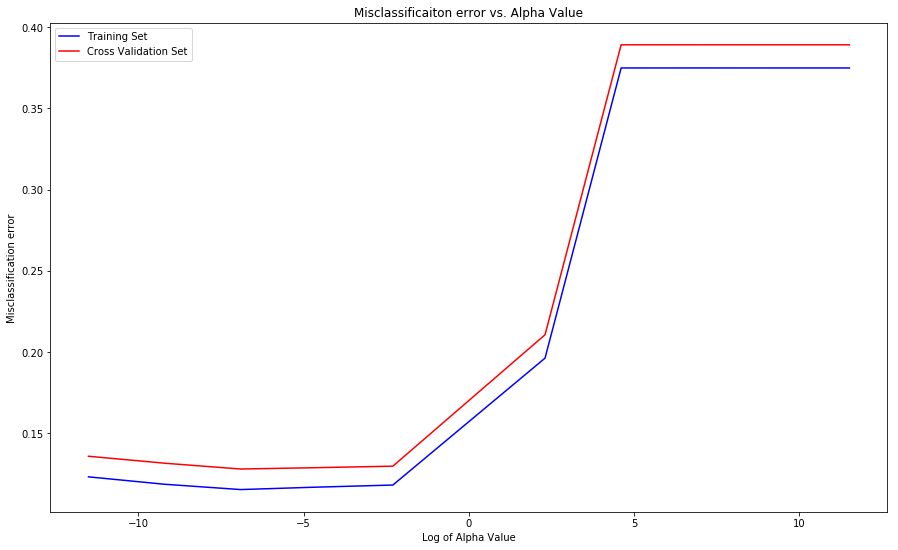

The optimal value of alpha is  0.001 with AUC Score : 0.8718756344481711


In [96]:


data=(tfidf_sent_vectors_train_cv,Y_TRAIN_CV,tfidf_sent_vectors_test_cv,Y_TEST_CV)
alpha=BEST_ALPHA_Linear(data)

Confusion matrix for train followed by test





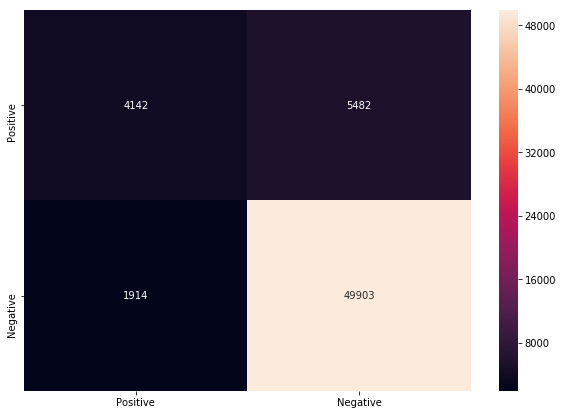

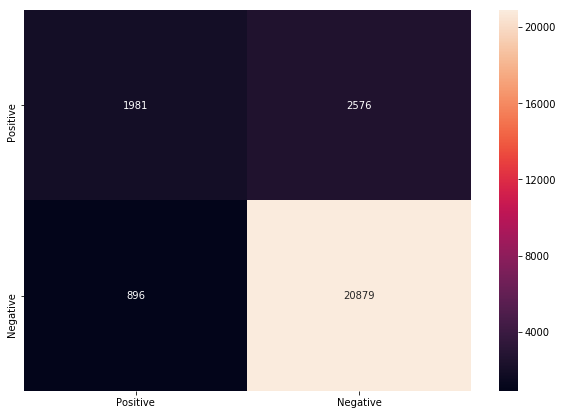

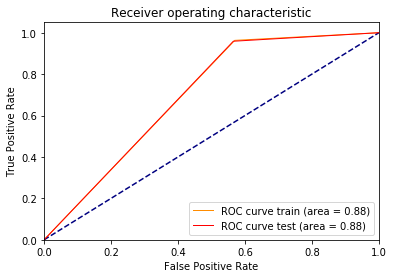

In [97]:
data=(tfidf_sent_vectors,Y_TRAIN,tfidf_sent_vectors_test,Y_TEST)
x=Linear_Svm(data,0.001)

In [98]:
print("The AUC score for alpha={} : {}".format(alpha,x[0]))

The AUC score for alpha=0.001 : 0.8769749419711591


## [5.2] RBF SVM WITH 20K DATA

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [0]:
# WITH ONLY 29K DATA

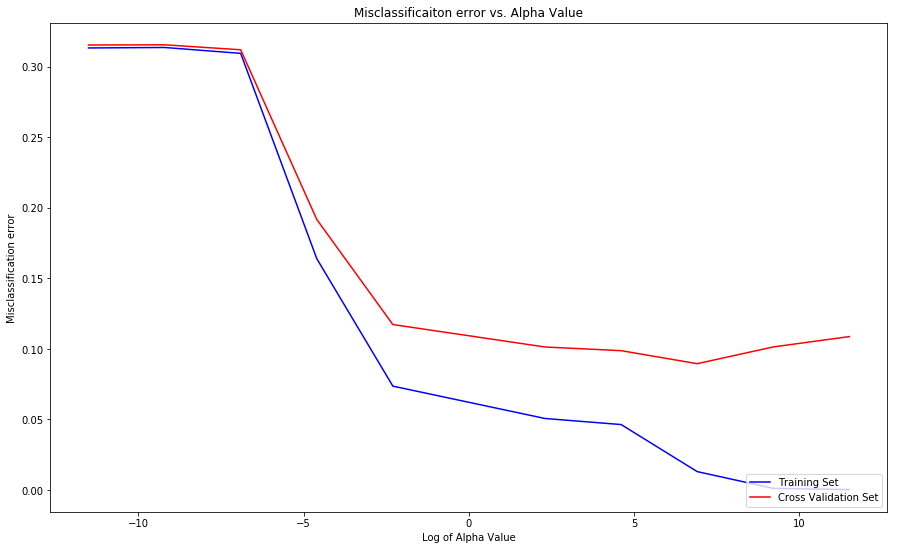

The optimal value of alpha is  1000 with AUC Score : 0.9104945375639035


In [100]:
data=(BOW_CV_TRAIN[:9800],Y_TRAIN_CV[:9800],BOW_CV_TEST[:4200],Y_TEST_CV[:4200])
alpha=BEST_ALPHA_rbf(data)

Confusion matrix for train followed by test





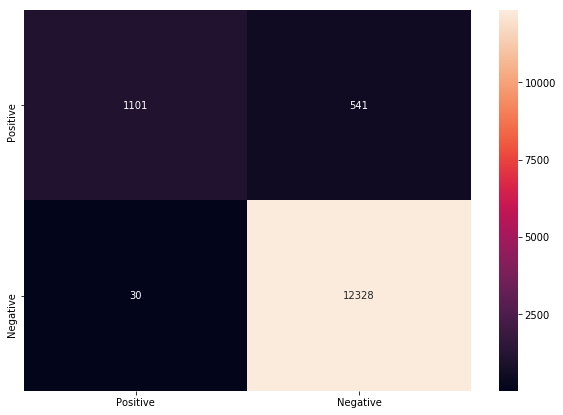

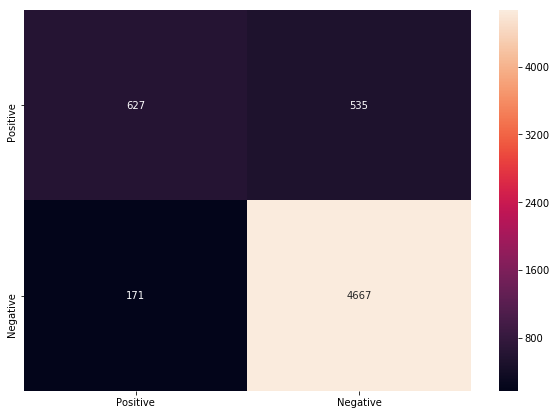

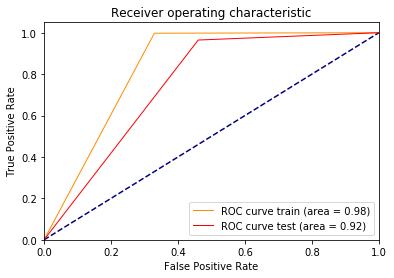

In [101]:

data=(BOW_TRAIN[:14000],Y_TRAIN[:14000],BOW_TEST[:6000],Y_TEST[:6000])
x=rbf_Svm(data,1000)

In [102]:
print("The AUC score for alpha={} : {}".format(1000,x[0]))

The AUC score for alpha=1000 : 0.9202893188533974


### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

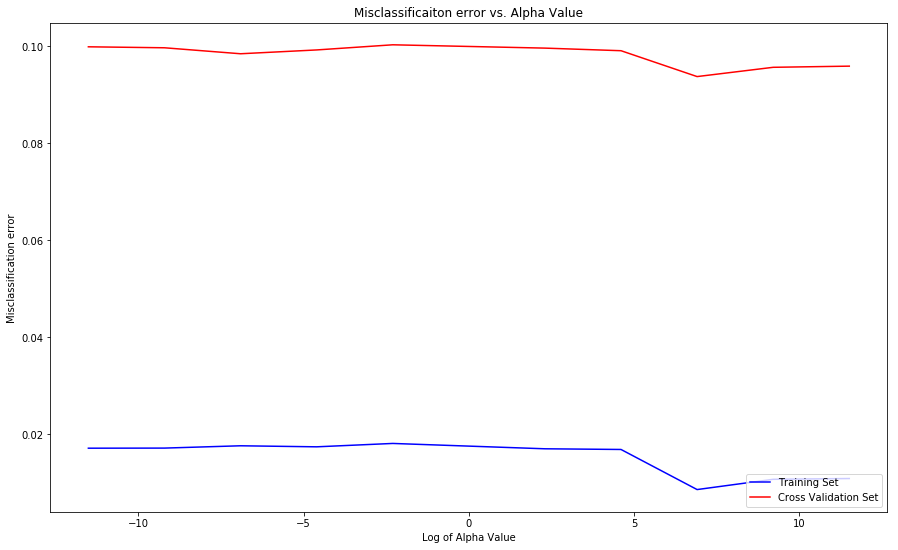

The optimal value of alpha is  1000 with AUC Score : 0.9062167905299671


In [105]:

data=(TF_CV_TRAIN[:9800],Y_TRAIN_CV[:9800],TF_CV_TEST[:4200],Y_TEST_CV[:4200])
alpha=BEST_ALPHA_rbf(data)

In [0]:
# Please write all the code with proper documentation

Confusion matrix for train followed by test





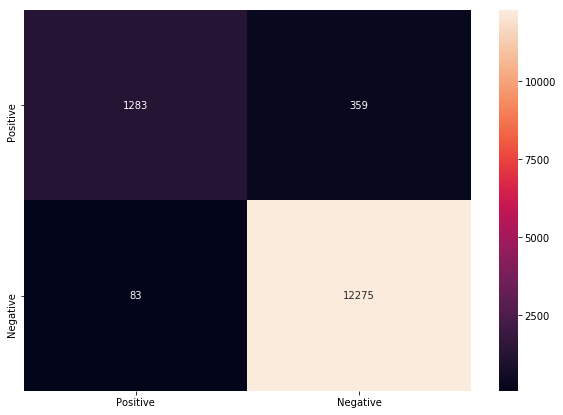

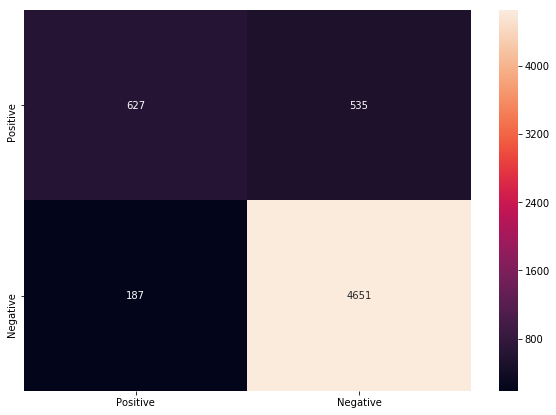

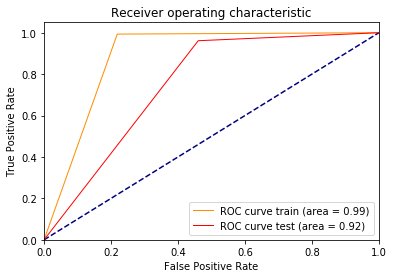

In [109]:

data=(TF_TRAIN[:14000],Y_TRAIN[:14000],tf_TEST[:6000],Y_TEST[:6000])

x=rbf_Svm(data,10000)

In [110]:
print("The AUC score for alpha={} : {}".format(10000,x[0]))

The AUC score for alpha=10000 : 0.9199996406816661


### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

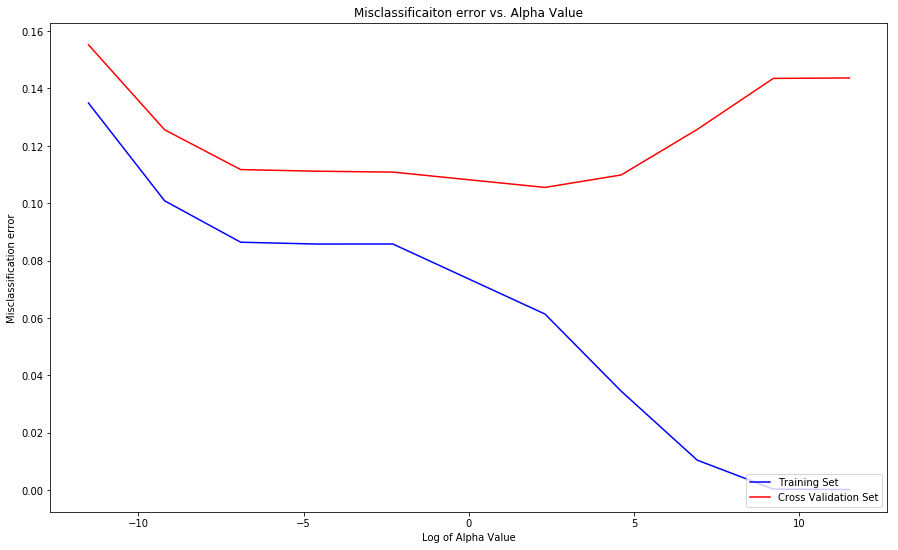

The optimal value of alpha is  10 with AUC Score : 0.8944809784169331


In [111]:




data=(sentences_train_cv[:9800],Y_TRAIN_CV[:9800],sentences_cv_test[:4200],Y_TEST_CV[:4200])
alpha=BEST_ALPHA_rbf(data)

Confusion matrix for train followed by test





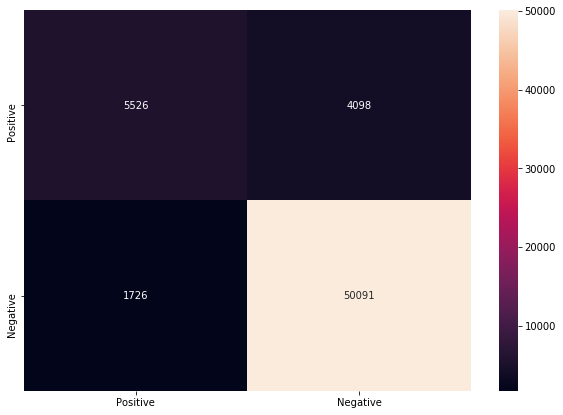

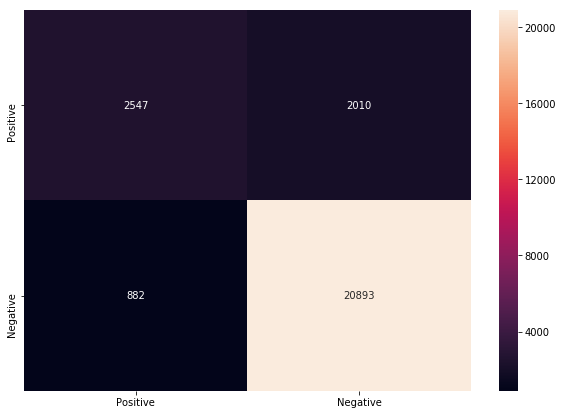

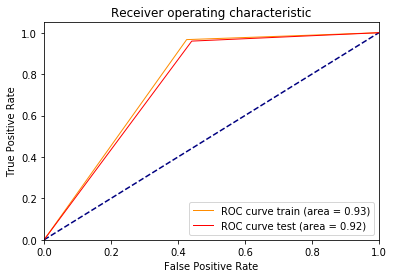

In [114]:
data=(sentences_train,Y_TRAIN,test_sentences,Y_TEST)
x=rbf_Svm(data,10)

In [112]:
print("The AUC score for alpha={} : {}".format(10,x[0]))

The AUC score for alpha=10 : 0.9199996406816661


### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

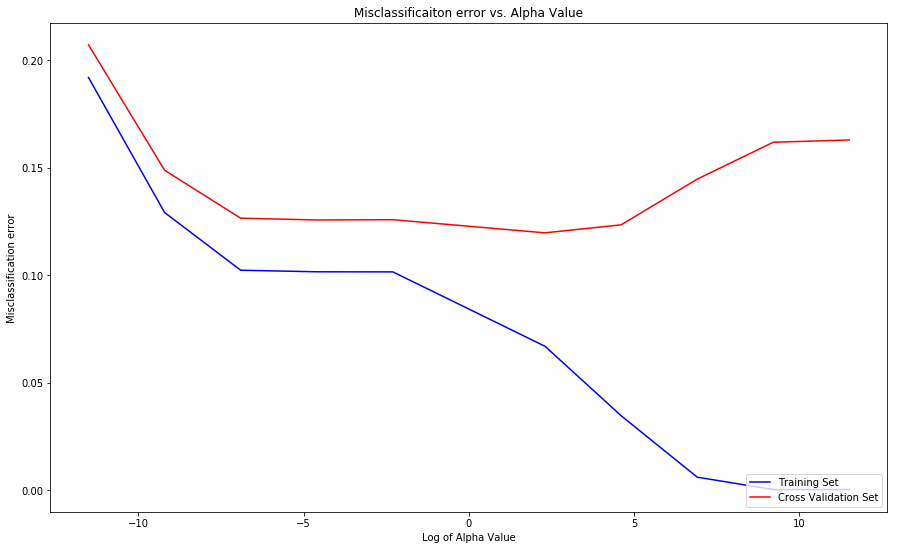

The optimal value of alpha is  10 with AUC Score : 0.8803588704094412


In [115]:
data=(tfidf_sent_vectors_train_cv[:9800],Y_TRAIN_CV[:9800],tfidf_sent_vectors_test_cv[:4200],Y_TEST_CV[:4200])
alpha=BEST_ALPHA_rbf(data)

Confusion matrix for train followed by test





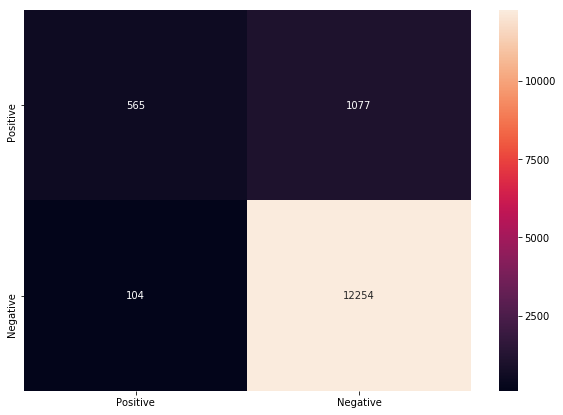

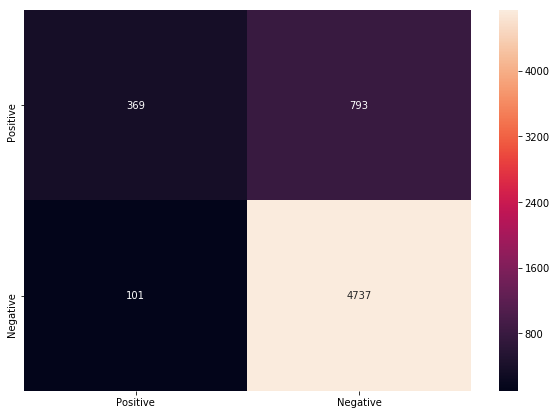

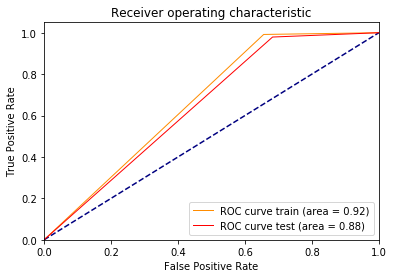

In [116]:
data=(tfidf_sent_vectors[:14000],Y_TRAIN[:14000],tfidf_sent_vectors_test[:6000],Y_TEST[:6000])
x=rbf_Svm(data,10)

In [117]:
print("The AUC score for alpha={} : {}".format(10,x[0]))

The AUC score for alpha=10 : 0.884321553621324


# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [119]:

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","Kernel","AUC Score","C"]

x.add_row(["BOW", "Linear","94.4%","10^-3"])
x.add_row(["BOW", "RBF","92%","1000"])
x.add_row(["TF-IDF", "Linear","95.6%","1e-05"])
x.add_row(["TF-IDF", "RBF","94%","10000"])
x.add_row(["AVG WORD2VEC", "Linear","90.3%","10^-3"])
x.add_row(["AVG WORD2VEC", "RBF","91.9%","10"])
x.add_row(["TF-IDF WORD2VEC", "Linear","87.9%","10^-3"])
x.add_row(["TF-IDF WORD2VEC", "RBF","88.43%","10"])



print(x)

+-----------------+--------+-----------+-------+
|      Model      | Kernel | AUC Score |   C   |
+-----------------+--------+-----------+-------+
|       BOW       | Linear |   94.4%   | 10^-3 |
|       BOW       |  RBF   |    92%    |  1000 |
|      TF-IDF     | Linear |   95.6%   | 1e-05 |
|      TF-IDF     |  RBF   |    94%    | 10000 |
|   AVG WORD2VEC  | Linear |   90.3%   | 10^-3 |
|   AVG WORD2VEC  |  RBF   |   91.9%   |   10  |
| TF-IDF WORD2VEC | Linear |   87.9%   | 10^-3 |
| TF-IDF WORD2VEC |  RBF   |   88.43%  |   10  |
+-----------------+--------+-----------+-------+




1.   TF-IDF VECTORIZER OUT PERFORMS ALL THE OTHER MODEL WITH 95% LINEAR MODEL PERFORMANCE AND 94% FOR RBF VERSION.
2.   THERE IS SIGNIFICANT VARIATION IN THE VALUE OF C.
3.    THE PERFORMANCE OF RBF VS LINEAR IS VERY SIMILAR AND THERE NOT MUCH DIFFERENCE

